- Developed by J. Vallee in 2025
- Jupyter NoteBook 7.3.2
- Anaconda Navigator 2.6.5
- Environment "YahooFinancials"

# Pre-Process

In [1]:
! python --version

Python 3.12.11


## Packages 

#### APIs
[Pandas](https://pandas.pydata.org/docs/reference/index.html)

In [2]:
! pip list | findstr "pandas mplfinance DateTime yfinance yahoofinancials fredapi"

DateTime                      5.5
fredapi                       0.5.2
mplfinance                    0.12.10b0
pandas                        2.3.0
yahoofinancials               1.20
yfinance                      0.2.63


In [1]:
import pandas             as pd      # manipulate dataframes
import numpy              as np      # math functions
from datetime import date as d       # handle dates
from datetime import datetime as dt  # handle timestamps
from datetime import timedelta       # add days to dates
import matplotlib.pyplot  as plt     # plot custom charts
import mplfinance         as mpf     # plot stock charts
import yfinance           as yf      # get stocks data
from IPython.display import HTML     # code in HTML
from yahoofinancials import YahooFinancials as yfs # get stocks from Yahoo Financials
from fredapi import Fred             # macro-economic data

## Functions

### Load

In [42]:
def read_df_from_csv(s_path):
    # headers: Datetime,Open,High,Low,Close,Volume
    #df_contents = pd.read_csv(s_path) .rename(columns={'Unnamed: 0': 'request_id'}) \
    df_contents = pd.read_csv(s_path).set_index('Datetime')
    return df_contents

In [13]:
def get_str_past_date(s_date, nb_past_days) :
    d_ref  = dt.strptime(s_date, S_DATE_FORMAT)
    d_past = d_ref - timedelta(days=nb_past_days)
    return d_past.strftime(S_DATE_FORMAT)  

In [8]:
def load_daily_from_yfinance(   ticker, start, end) :
    # valid intervals : 1 2 5 15 30 60 90m 1h 1 5d 1wk 1 3mo
    df_multi_index = yf.download(ticker, start, end, interval='1d', auto_adjust=False, group_by=ticker)
    df_out = df_multi_index[ticker]
    return df_out[LI_COLS]

In [32]:
def standardize_yfs_df(df_in) :
    LI_YFS_COLS = ['formatted_date', 'open', 'close', 'high', 'low', 'volume']
    df_out = df_in[LI_YFS_COLS].copy()
    df_out.rename(columns={'formatted_date':  'Date'}, inplace=True)
    df_out.columns = df_out.columns.str.capitalize()
    df_out.set_index('Date', inplace=True)
    df_out.index = pd.to_datetime(df_out.index)
    return df_out

In [23]:
def load_daily_from_yfinancials(ticker, start, end) :
    yfs_ticker = yfs(ticker)
    bool_yfs_is_OK = ( yfs_ticker.get_current_price() > 0 )
    if bool_yfs_is_OK :
        try :
            js_stocks = yfs_ticker.get_historical_price_data(start, end, 'daily')
            df_out = pd.DataFrame(js_stocks[ticker]['prices']) 
        except Exception as except_yfs : 
            print( type(except_yfs).__name__ )
    else :
        s_command = f"yfs('{ticker}').get_historical_price_data('{start}', '{end}', 'daily')"
        print('YahooFinancials has issues at this moment, this command :\n', s_command)
        print('returns :\n', js_stocks)
        str_error = 'No price records sent by Yahoo Financials' 
        assert False, (str_error)
    return standardize_yfs_df(df_out)

In [8]:
def load_daily_from_local(ticker, start, end) :
    df_multi_index = yf.download(ticker, start, end, interval='1d', auto_adjust=False, group_by=ticker)
    df_out = df_multi_index[ticker]
    return df_out[LI_COLS]

In [11]:
def load_daily_from(s_provider, ticker, nb_days, s_end_date_excluded) :
    s_start_date = get_str_past_date(s_end_date_excluded, nb_days) 
    print(f'Daily data from {s_provider} for {ticker} on period [{s_start_date};{s_end_date_excluded}>' )
    if   s_provider == 'yfinance' :        
        return load_daily_from_yfinance(   ticker, nb_days, s_start_date, s_end_date_excluded)
    elif s_provider == 'yahoofinancials' : 
        return load_daily_from_yfinancials(ticker, nb_days, s_start_date, s_end_date_excluded)
    elif s_provider == 'local' : 
        return load_daily_from_local(ticker, nb_days, s_start_date, s_end_date_excluded)
    else :
        str_error = 'Unknown stock data provider'
        assert False, (str_error) # prevents execution of following cells

In [9]:
# To do : write to / read from csv file cf. video 1:25:33

### Missing Values

In [10]:
def handle_missing_values(df_in) :
    bl_has_missing_values = ( df_in.isna().sum().sum() > 0 )
    if bl_has_missing_values : 
        str_error = 'DatFrame contains missing values but handling them is still pending'
        assert False, (str_error) # prevents execution of following cells
    else :
        print('DatFrame contains NO missing values')

In [11]:
get_NaN_dates = lambda df_in, str_col : df_in[df_in[str_col].isna()].index.strftime('%Y-%m-%d').to_list()

### Plot Candlesticks Chart

In [12]:
def get_subset_to_plot(df_in, max_nb_trades=599) :
    if len(df_in) >= 600 :
        max_nb_trades  # <600 to avoid "Too much data" warning
        df_subset = df_in.tail(max_nb_trades)  # only last 600 trades are plotted 
        return df_subset
    else :
        return df_in

In [13]:
def plot_chart(df_in, s_title, li_mav=[], li_addplots=[], bo_add_Volume=True, i_width=12, i_height=5, bo_show_legend=False) :
    '''
    Plots a candlestick chart with optional Volume.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        s_title (str): chart's title
        bo_add_Volume (bool, optional): If True (default), adds a volume subplot
    '''
    df_subset = get_subset_to_plot(df_in)
    fig, axes = mpf.plot(df_subset, type='candle', title=s_title, volume=bo_add_Volume, figsize=(i_width, i_height), 
                        mav=li_mav,           # moving average curves             
                        addplot=li_addplots,  # append other curves in current or additional panels 
                        style='yahoo',        # other styles: binance, nightclouds
                        returnfig=True        # allows to return axes
                )
    if bo_show_legend :
        axes[1].set_yticks([])
        axes[1].legend(loc='upper left')
    plt.show()
    plt.close()

In [14]:
def append_macd (df_in, bo_add_Volume, li_addplots=[]) :
    '''
    Calculates 3 indicators (MACD Signal lines + MACD Histogram) and appends them to a list.

    Args:
        df_in (pd.DataFrame): input DataFrame with index Date and columns Open, High, Low, Close, Volume
        bo_add_MACD   (bool, optional): If True (default), adds 
    '''
    # Calculate MACD (trend of a trend) 
    # with ewm() = Exponential Weighted Moving average
    df_fast_average = df_in['Close'].ewm(span=12, adjust=False).mean() 
    df_slow_average = df_in['Close'].ewm(span=26, adjust=False).mean()
    df_fast_trend   = df_fast_average - df_slow_average
    df_slow_trend   = df_fast_trend.ewm(span=9, adjust=False).mean()
    df_trend_of_trend = df_fast_trend - df_slow_trend
    df_in.loc[:, 'MACD']   = df_slow_trend
    df_in.loc[:, 'Signal'] = df_fast_trend
    df_in.loc[:, 'Hist_pos'] = df_trend_of_trend.map(lambda x: x if x > 0 else 0)
    df_in.loc[:, 'Hist_neg'] = df_trend_of_trend.map(lambda x: x if x < 0 else 0)

    # Append MACD curves to chart 
    df_subset = get_subset_to_plot(df_in)  # only last 600 trades are plotted 
    if bo_add_Volume :  hist_panel = 2
    else             :  hist_panel = 1
    signal_panel = hist_panel + 1
    li_addplots = [        
        mpf.make_addplot(df_subset[['Hist_pos']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='green'),
        mpf.make_addplot(df_subset[['Hist_neg']], type='bar',  panel=hist_panel,   ylabel='Histogram', color='red'),
        mpf.make_addplot(df_subset[['MACD']]    , type='line', panel=signal_panel, ylabel='MACD', color='gray', label='MACD'),
        mpf.make_addplot(df_subset[['Signal']]  , type='line', panel=signal_panel, ylabel='Signal', color='orange')
    ]
    return li_addplots

In [15]:
def plot_pattern_sample(df_in, li_dates, s_pattern, delta=5) : 
    # dates range = d_last_occurrence +- delta
    if li_dates == [] : print('Pattern not found in dataset')
    else :
        d_last_occurrence = li_dates[-1]
        print('d_last_occurrency ' + s_pattern, d_last_occurrence)
        t_delta = timedelta(days=delta)
        d_start = d_last_occurrence - t_delta
        d_end   = d_last_occurrence + t_delta
        df_subset = df_in.loc[d_start : d_end]
        plot_chart(df_subset, 'Last Occurrency of ' + s_pattern, 
                   li_mav=[], li_addplots=[], bo_add_Volume=False, i_width=7, i_height=2)

In [16]:
def append_pattern(df_in, s_pattern, s_color) :
    df_subset = get_subset_to_plot(df_in)
    return mpf.make_addplot(df_subset[[s_pattern]], type='bar', color=s_color, alpha=0.3, label=s_pattern)

In [17]:
def plot_pattern_full(df_in, s_pattern, li_mav=[], bo_volume=False, i_width=15, i_height=5, s_color='cyan') :
    s_title = s_pattern + ' on chart'
    li_addplots = [ append_pattern(df_in, s_pattern, s_color) ]
    plot_chart(df_in, s_title, li_mav, li_addplots, bo_volume, i_width, i_height)

### Candlesticks

In [18]:
li_main_prices = ['Open', 'Close', 'High', 'Low'] 

#### Get Dimensions of a Candle 

In [19]:
def get_candle_dims(trade) :
    open_, close, high, low = trade[li_main_prices]
    body       = abs(open_         - close) 
    range_     = high              - low
    upper_wick = high              - max(close, open_)
    lower_wick = min(close, open_) - low
    return body, range_, upper_wick, lower_wick

#### Get Top & Bottom of all candles' bodies 

In [20]:
def get_body_top   (df_in) : 
    return np.maximum(df_in['Open'] , df_in['Close']) # get max value from 2 DF columns 

def get_body_bottom(df_in) :      
    return np.minimum(df_in['Open'] , df_in['Close']) # get min value from 2 DF columns

### Candlestick Patterns

#### Doji

In [21]:
def is_doji(trade) : # A Doji's body is much smaller than its range
    body, range_, _, _     = get_candle_dims(trade)
    ratio_body_range = 0.1
    bo_is_doji = ( body <= ratio_body_range * range_ )
    return bo_is_doji

<img src='https://img.investingoal.com/app/uploads/2024/11/long-legged-doji-candlestick-pattern.jpg' width='400px'>

#### Inverted Hammer

In [22]:
def is_inv_hammer(trade) : # An Inverse Hammer's body is very close to its Low
    body, _, upper_wick, lower_wick = get_candle_dims(trade)
    ratio_up_wick_body = 2
    ratio_lo_wick_body = 0.1
    bo_is_inv_hammer = ( ( upper_wick >= ratio_up_wick_body * body ) and
                         ( lower_wick <= ratio_lo_wick_body * body ) )
    return bo_is_inv_hammer

<img src='https://media.assettype.com/tnm/import/sites/default/files/images/image1%20(2)(5).png' width='400px'>

#### Hammer

In [23]:
def is_hammer(trade) : # A Hammer's body is very close to its High
    body, _, upper_wick, lower_wick = get_candle_dims(trade)
    ratio_up_wick_body = 0.1
    ratio_lo_wick_body = 2
    bo_is_hammer = ( ( upper_wick <= ratio_up_wick_body * body ) and
                     ( lower_wick >= ratio_lo_wick_body * body ) )
    return bo_is_hammer

<img src='https://ninjatrader.com/getattachment/5e35b7c2-7054-4f8a-8356-f2efc79202f9/bullish-hammer-image.png' width='400px'>

#### Bullish/Bearish Engulfing

In [24]:
def get_curr_prev_dfs(df_in) :
    # Create 2 DFs to compare columns rather than pairs of consecutive records
    df_curr = df_in[li_main_prices].copy()
    df_prev = df_curr.shift(1)    
    df_prev.iloc[0] = df_prev.iloc[1]    # Prev : replace 1st row's NaN by 2nd row value
    return df_curr, df_prev

In [25]:
def is_bull_bear_engulf(df_in) :
    df_curr, df_prev = get_curr_prev_dfs(df_in) 
    
    # Get series of Engulfing Candles
    se_high_increased   = ( df_curr['High']          > df_prev['High'] )
    se_low_decreased    = ( df_prev['Low']           > df_curr['Low'] )
    se_top_increased    = ( get_body_top   (df_curr) > get_body_top   (df_prev) )
    se_bottom_decreased = ( get_body_bottom(df_prev) > get_body_bottom(df_curr) )
    se_engulfing        = se_high_increased & se_low_decreased & se_top_increased & se_bottom_decreased

    # Get series of Bullish Candles (current & previous)
    se_prev_bullish     = ( df_prev['Close']      > df_prev['Open'] ) 
    se_curr_bullish     = ( df_curr['Close']      > df_curr['Open'] )    
    
    se_bullish_engulf   = ( se_engulfing & se_curr_bullish     & ~se_prev_bullish ) # Get series of Bullish Engulfings
    se_bearish_engulf   = ( se_engulfing & ~se_curr_bullish    &  se_prev_bullish ) # Get series of Bearish Engulfings
    
    return se_bullish_engulf, se_bearish_engulf

<img src='https://fxpipsgainer.com/wp-content/uploads/2022/03/Bullish-and-Bearish-Engulfing.png' width='400px'> 

### Curves

#### SMA

In [26]:
get_sma = lambda ser_in, window_width : ser_in.rolling(window_width).mean()

#### Crossing Curves

<img src='https://aximedia.s3.amazonaws.com/rebrand-prod/rpfccnxi/how-to-understand-moving-average.png'  width='500px'>

##### Get crossing points of 2 curves

In [27]:
def get_crossings(sr_short, sr_long) :
    sr_short_prev      = sr_short.shift(1)              # get Short previous values
    sr_prev_was_lower  = ( sr_short_prev <= sr_long )   # before crossing
    sr_prev_was_higher = ~sr_prev_was_lower
    sr_curr_is_higher  = ( sr_short      >= sr_long )   # after  crossing
    sr_curr_is_lower   = ~sr_curr_is_higher
    sr_cross_above     = ( sr_prev_was_lower  & sr_curr_is_higher )
    sr_cross_below     = ( sr_prev_was_higher & sr_curr_is_lower )
    return remove_trailing_Trues(sr_cross_above), remove_trailing_Trues(sr_cross_below)

##### Remove trailing True values from DF

In [28]:
def remove_trailing_Trues(sr_in) :
    sr_prev = sr_in.shift(1)            # get previous values
    d_1st_trade = sr_prev.index[0]      # replaces deprecated fillna
    sr_prev.loc[d_1st_trade] = False    # replace first row NaN to False
    sr_prev = sr_prev.astype(bool)
    sr_out = sr_in & ~sr_prev
    sr_out.loc[d_1st_trade] = False     # replace first row NaN to False
    return sr_out

### Earnings

In [29]:
def get_balance(df_in, s_col_price, s_col_buy, s_col_sell, bo_verbose=True) :
    # A single share is bought or sold per action
    sold_qty      = df_in[s_col_sell].sum()  # all amounts' type is numpy.int64
    bought_qty    = df_in[s_col_buy ].sum()
    last_price    = df_in[s_col_price].iloc[-1]
    current_total = last_price * ( bought_qty - sold_qty)
    sold_total   = ( df_in.loc[df_in[s_col_sell], s_col_price] * 1 ).sum()
    bought_total = ( df_in.loc[df_in[s_col_buy],  s_col_price] * 1 ).sum()
    balance      = current_total + sold_total - bought_total
    if bo_verbose :
        print('sold_qty=', sold_qty, 'bought_qty=', bought_qty)
        print('current_total=', current_total)
        print('last_price=', last_price)
        print('sold_total=', sold_total, 'bought_total=', bought_total)    
    return int(balance)   # casts np.int -> int

In [30]:
def get_2SMA_balance(df_in, i_short, i_long, sr_close) :
    sr_short = get_sma(sr_close, i_short)
    sr_long  = get_sma(sr_close, i_long)
    df['2SMA_Buy'], df_in['2SMA_Sell'] = get_crossings(sr_short, sr_long)
    return get_balance(df_in, 'Close', '2SMA_Buy', '2SMA_Sell', bo_verbose=False)     

# Main Process

## Load

In [15]:
S_DATE_FORMAT = '%Y-%m-%d'
LI_COLS = ['Open', 'Close', 'High', 'Low', 'Volume']

### Choose Stock & Dates

In [2]:
s_stock_ref = 'RELIANCE.NS' # Nifty 50 '^NSEI' 'RELIANCE.NS'
nb_days     = 10
s_end_date  = d.today().isoformat()

### Choose Provider
- [yFinance](https://ranaroussi.github.io/yfinance/reference/index.html) : basic
- [Yahoo Financials](https://github.com/JECSand/yahoofinancials) : advanced includes metrics

In [3]:
s_provider = 'yahoofinancials' # 'yahoofinancials' 'yfinance' 'local'

### Get Data as DF

In [33]:
df = load_daily_from(s_provider, s_stock_ref, nb_days, '2025-06-25') #s_end_date)
df.head(1)

Daily data from yahoofinancials for RELIANCE.NS on period [2025-06-15;2025-06-25>


,Open,Close,High,Low,Volume
Date,,,,,
2025-06-16,1426.900024,1437.800049,1442.400024,1424.400024,8458093


## Clean

Check DF including missing values

In [ ]:
df.info()

### Handle missing values

In [ ]:
handle_missing_values(df)

## Visualise w/o patterns

In [ ]:
li_addplots = []

In [ ]:
s_title       = s_stock_ref + ' Chart with MACD'
li_mav        = [12, 26]
bo_add_Volume = True
df_subset     = get_subset_to_plot(df)
li_addplots   = append_macd(df_subset, bo_add_Volume)
plot_chart(df, s_title, li_mav, li_addplots, bo_add_Volume=bo_add_Volume, bo_show_legend=False)

# Features  
- candlestick patterns
- internal
    - from shifted DF
    - SMAs
    - Volume
    - price delta
- indicators
    - volatility
    - sentiment
    - FED's interest rate
    - US unemployment rate

## Patterns

### Candlesticks

In [ ]:
li_candle_patterns = ['Doji', 'InvHammer', 'Hammer','BullEngulf', 'BearEngulf']

#### Append 1 DF column per pattern

##### Doji & Hammers

In [ ]:
df['Doji']      = df.apply(is_doji,       axis=1) # 1: applies to rows
df['InvHammer'] = df.apply(is_inv_hammer, axis=1)
df['Hammer']    = df.apply(is_hammer,     axis=1)

##### Bullish/Bearish Engulfing

In [ ]:
# Append as columns 2 series of occurrencies of Bullish & Bearish Engulfings
df['BullEngulf'] , df['BearEngulf'] = is_bull_bear_engulf(df)

### Check pattern occurrency dates

In [ ]:
get_li_pattern_dates = lambda str_pattern : df[df[str_pattern]].index.strftime('%Y-%m-%d').to_list()

In [ ]:
for str_pattern in li_candle_patterns :
    print(f'{str_pattern:<15} : {get_li_pattern_dates(str_pattern)[:5]}' )

#### Plot most recent occurency per pattern

In [ ]:
li_patterns = ['Doji', 'InvHammer', 'Hammer', 'BullEngulf', 'BearEngulf']
for s_pattern in li_patterns :
    li_dates = df[df[s_pattern]].index.to_list()
    print(s_pattern, ':', len(li_dates), 'ocurrencies')
    plot_pattern_sample(df, li_dates, s_pattern)

#### Plot Candle patterns in a single chart

In [ ]:
s_title       = 'Candle Patterns on chart'
li_mav        = [12, 26]
bo_add_Volume = False
li_addplots   = [   append_pattern(df, 'Doji',       'cyan'),
                    append_pattern(df, 'InvHammer',  'yellow'),
                    append_pattern(df, 'Hammer',     'orange'),
                    append_pattern(df, 'BullEngulf', 'green'),
                    append_pattern(df, 'BearEngulf', 'pink')
                ]
plot_chart(df, s_title, li_mav, li_addplots, bo_add_Volume=bo_add_Volume)

#### Plot 1 Candle pattern per chart

In [ ]:
for s_pattern in ['Doji', 'InvHammer', 'Hammer', 'BullEngulf', 'BearEngulf'] :
    plot_pattern_full(df, s_pattern, li_mav, i_width=15, i_height=3, s_color='orange')
plt.show()

## SMA Crossings

In [ ]:
sr_close = df['Close']

### Strategy 1-SMA

#### Closing Price vs. Long-Period SMA
Buy when Closing Price curve exceeds Long-Term and Sell when it subceeds

In [ ]:
i_long = 17  # nb of days
sr_long  = get_sma(sr_close, i_long)

In [ ]:
df['1SMA_Buy'], df['1SMA_Sell'] = get_crossings(sr_close, sr_long)

#### Plot 1-SMA

In [ ]:
s_title     = 'Close vs. 1-SMA Crossings'
li_mav      = [i_long]
li_addplots = [   append_pattern(df, '1SMA_Buy',  'orange'),
                  append_pattern(df, '1SMA_Sell', 'cyan')
              ]
plot_chart(df, s_title, li_mav, li_addplots, bo_add_Volume=False, i_width=40, i_height=5)

In [ ]:
print('Balance=', get_balance(df, 'Close', '1SMA_Buy', '1SMA_Sell') )

### Strategy 2-SMA
#### Short vs. Long Period SMAs
Buy when Short-Term curve exceeds Long-Term and Sell when it subceeds

In [ ]:
i_short, i_long = 8, 29 # nb of days
sr_short = get_sma(sr_close, i_short)
sr_long  = get_sma(sr_close, i_long)

Identify Crossings to detect when Short-Term curve subceeds and exceeds Long-Term

In [ ]:
df['2SMA_Buy'], df['2SMA_Sell'] = get_crossings(sr_short, sr_long)

#### Plot 2-SMA

In [ ]:
s_title     = 'Crossings on chart'
li_mav      = [i_short, i_long]
df_subset   = get_subset_to_plot(df)
li_addplots = [   append_pattern(df, '2SMA_Buy',  'orange'),
                  append_pattern(df, '2SMA_Sell', 'cyan')
              ]
plot_chart(df, s_title, li_mav, li_addplots, bo_add_Volume=False, i_width=40, i_height=5)

In [ ]:
print('Balance=', get_balance(df, 'Close', '2SMA_Buy', '2SMA_Sell') )

#### 2-SMA Optimisation

In [ ]:
i_short, i_long = 8, 29 # nb of days

In [ ]:
li_results = []  # list of tuples (short period, long period, balance)
for i_short in range(3, 14) :
    for i_long in range(15, 50) :
        i_balance = get_2SMA_balance(df, i_short, i_long, sr_close)
        if i_balance > 0 : li_results.append( (i_short, i_long, i_balance) ) 

In [ ]:
li_top_5 = sorted(li_results, key=lambda x:x[2], reverse=True)[:5] # get top 10 balance amounts
pd.DataFrame(li_top_5, columns=['SMA-A', 'SMA-B', 'Balance'])

## Indicators
### Volatility Index
CBOE Volatility Index (VIX) is traded like a stock or ETF

In [ ]:
s_stock_ref = '^VIX'
df_vix = load_daily_from(s_provider, s_stock_ref, nb_days, s_end_date)
df_vix.head(1)

In [ ]:
df['VIX'] = df_vix['Close'] #.shift(1)

In [ ]:
df['VIX'].head(1)

In [ ]:
df['VIX'].info()

In [ ]:
get_NaN_dates(df, 'VIX')

In [ ]:
df[df['VIX'].isna()].index.strftime('%Y-%m-%d').to_list()

In [ ]:
s_title     = 'Volatility on chart'
li_mav      = [] #[i_short, i_long]
df_subset   = get_subset_to_plot(df)
li_addplots = [ mpf.make_addplot(df_subset[['VIX']], type='line', color='blue') ]
plot_chart(df_subset, s_title, li_mav, li_addplots, bo_add_Volume=False, i_width=40, i_height=5)

### Macro-Economic
[Get free FRED API key](https://fred.stlouisfed.org/docs/api/api_key.html)

In [37]:
s_start_date = get_str_past_date(s_end_date, max(nb_days, 120) )

Get API key from local file

In [35]:
with open('FRED_api_key/key.txt') as file_w_key: str_key = file_w_key.read()
fred = Fred(api_key=str_key)

#### Rates from [Federal Reserve](https://fred.stlouisfed.org/categories)

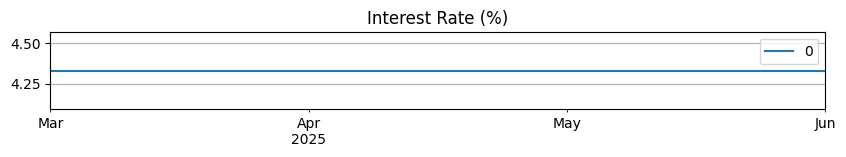

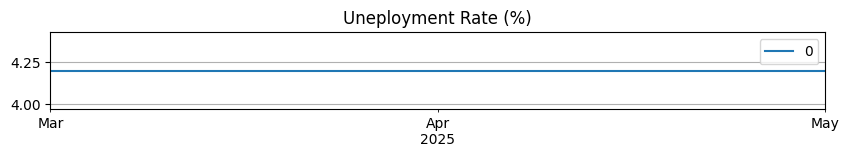

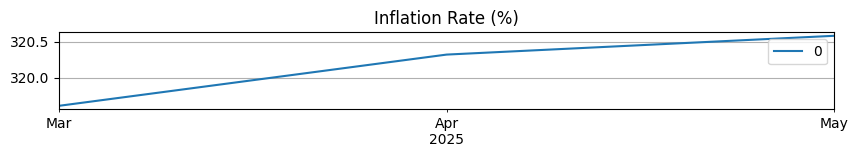

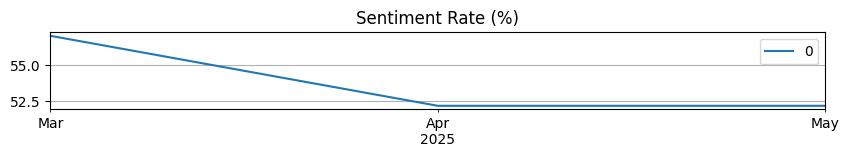

In [38]:
li_fred_rates = ['FEDFUNDS', 'UNRATE',      'CPIAUCSL',  'UMCSENT']
li_fred_cols  = ['Interest',    'Uneployment', 'Inflation', 'Sentiment']
for str_rate, str_prefix in zip(li_fred_rates,li_fred_cols) :
    ser_rate = fred.get_series(str_rate, observation_start=s_start_date)
    str_col = str_prefix + ' Rate (%)'
    pd.DataFrame(ser_rate).plot(title=str_col, figsize=(10,1), grid=True)
    plt.show()

# ToDo : 
- implement ML w/ train-validate-test partition & feature engineering